In [335]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm  

# Time series analysis
In this analysis we aim to predict the `number of accidents` and the `severity of the accidents`.

## Setting up the dataset
It is our intention to create a "found" time series, that is a dataset which is properly cleaned and structured to work with state of the art time series analysis algorithms. The reason for this is that our original Kaggle dataset was not intended to be used for time series analysis and was therefore not organized as such.

In the following, we'll look at the main problems with this dataset, before outlining the strategy we've developed to address them.

### The problem of a messy dataset
The reader should bear in mind that the dataset used is a *government dataset*. As such, due to politics, budgets and other exogenous considerations, missing and inaccurate values, incomplete rows and discontinuities should be expected.

And that's not even the half of it. Given the nature of the dataset we should expect the *time discounting* phenomenom to hinder the accuracy of the recorded information. More specifically, as this is an accident-related dataset, the event is recorded after the intervention of a traffic officer and after a report has been written. This means that the timestamp of the registration is likely to be distant from the timestamp of the accident, and details outside the report may be misreported, due to the *time discounting* phenomenom.

What's more, once we have removed all the columns other than the ones we are interested in analysing, namely `Date`, `Time` and `Accident_Severity`, we notice that there are a few rows with at least one null value in these three columns. To be more precise, we are talking about a total of 156 rows.

To address the latter issue, we have several strategies.

1. **Infer the missing values from other fields by exploiting existing functional dependencies**. For example, if the null value is under the `Date` column, and we can assume that at least one accident occurred every day, we can sort the rows by the `Accident_Index` column and, based on the `Time` field, impute the missing value from the previous or next event.
2. **Interpolate missing values using the previous and next accidents**. For example, if the missing value is under the `Time` column, we can sort the rows by the `Accident_Index` column and assign to the `Time` field the linear interpolation between the two closest accidents. To be even more precise, we can calculate the statistical distribution of the delay between two subsequent events over the entire dataset and then use it to maximise the probability of the missing value. In more practical terms, if the missing value is $y_t$ and the probability density function of the lags inferred from the population is $f_x$, we need to maximize $f(y_t-y_{t-1})+f(y_{t+1}-y_t)$.
   <p align="center">
    <img src="img/delays_distribution.png" width="50%"/>
</p>

3. **Use moving mode to choose the missing value**. For example, if the `Accident_Severity` column is missing a value, we could try to fill it in based on the mode of the *k* preceding values.
4. **Entierly remove the rows in question**. If the rows with missing values are not too many compared to the others, and they don't have any relevance as outliers, we can safely remove them.

### The problem of daylight savings time
<p align="center">
    <img src="img/time_zone.png" width="30%"/>
</p>

As the dataset is based on accidents that took place in the United Kingdom, the problem of time zone mismatch does not arise. In fact, the whole country is in the UTC time zone, so not only do we not have to worry about multiple time zones based on latitude and longitude values, but also we have equivalence between UTC and the local time zone.

However, there's still the problem of daylight savings time, which causes some instants to occur twice a year and others to not exist at all.

In [4]:
DATASET_NAME = 'Accident_Information'
USE_CACHED = True

In [5]:
df_original = pd.read_csv(f'../dataset/{DATASET_NAME}{'[time_series]'if USE_CACHED else ''}.csv', low_memory=False)

In [6]:
df = df_original if USE_CACHED else (
    df_original[['Accident_Severity', 'Date', 'Time',
                 'Number_of_Casualties', 'Number_of_Vehicles']]
    .assign(timestamp=pd.to_datetime(df_original['Date'] + ' ' + df_original['Time']))
    .drop(columns=['Date', 'Time'])
)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df=df.rename({'Number_of_Casualties': 'number_of_casualties',
          'Number_of_Vehicles': 'number_of_vehicles'}, axis='columns')

In [7]:
f'Original size = {df_original.size/1024 **
                   2:.2f} MB', f'Pruned size = {df.size/1024**2:.2f} MB'

('Original size = 7.81 MB', 'Pruned size = 7.81 MB')

In [8]:
print(f'{len(df[df.isnull().any(axis=1)])
         } rows have a null value, so I remove them')
df = df.dropna()

156 rows have a null value, so I remove them


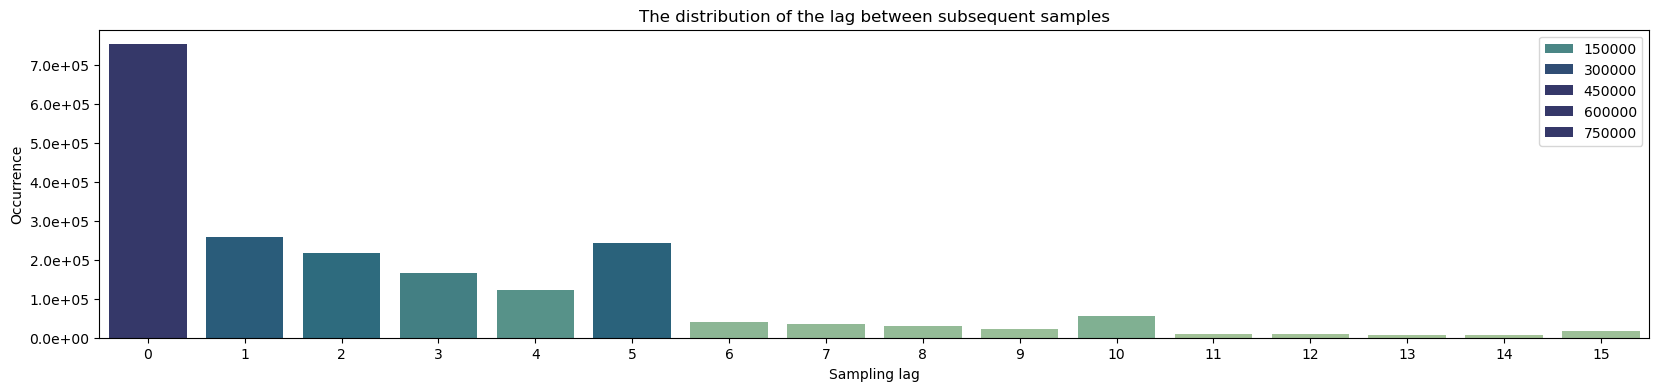

In [9]:
df = df.sort_values(by='timestamp')
df['step'] = (df['timestamp'].diff().dt.total_seconds() / 60).fillna(0)
value_counts = df[df['step'] <= 15]['step'].value_counts().sort_index()

plt.figure(figsize=(20, 4))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='crest', hue=value_counts.values,hue_norm=(1,350000))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1e}'))
plt.title('The distribution of the lag between subsequent samples')
plt.xlabel('Sampling lag')
plt.ylabel('Occurrence')
plt.show()

Here a new problem arises, a large proportion of the events (36.75%) are less than 1 minute apart in different locations in the UK, whereas the granularity of the recording is 1 minute. This means that **these events collapse into a single point in time**.

### Data downsampling through aggregation

We solve most of the problems listed so far by downsampling the data. This choice is justified by the large number of rows in our dataset. In fact, there are 2,047,100 rows with no null values in the columns of interest. The choice is also heavily influenced by the unevenness of the sampling rate, as shown in the previous bar chart.

The time series is therefore downsampled using the *count* aggregation, **daily**, **weekly** and **monthly**. We're careful not to introduce *lookahead*, in the sense that each point should not be aggregated to a new timestamp less than its current one, **to avoid carrying information backwards**. In other words, the number of accidents in a month up to its last day is calculated by counting all the accidents that have occurred since the first day of the very month. 

Following this lead, we'll obtain three datasets, one for each level of aggregation. Each of them will consist of the columns `number_of_accidents`, `number_of_casualties` and `number_of_vehicles`. The distribution of the number of casualties and vehicles involved per accident is shown below.

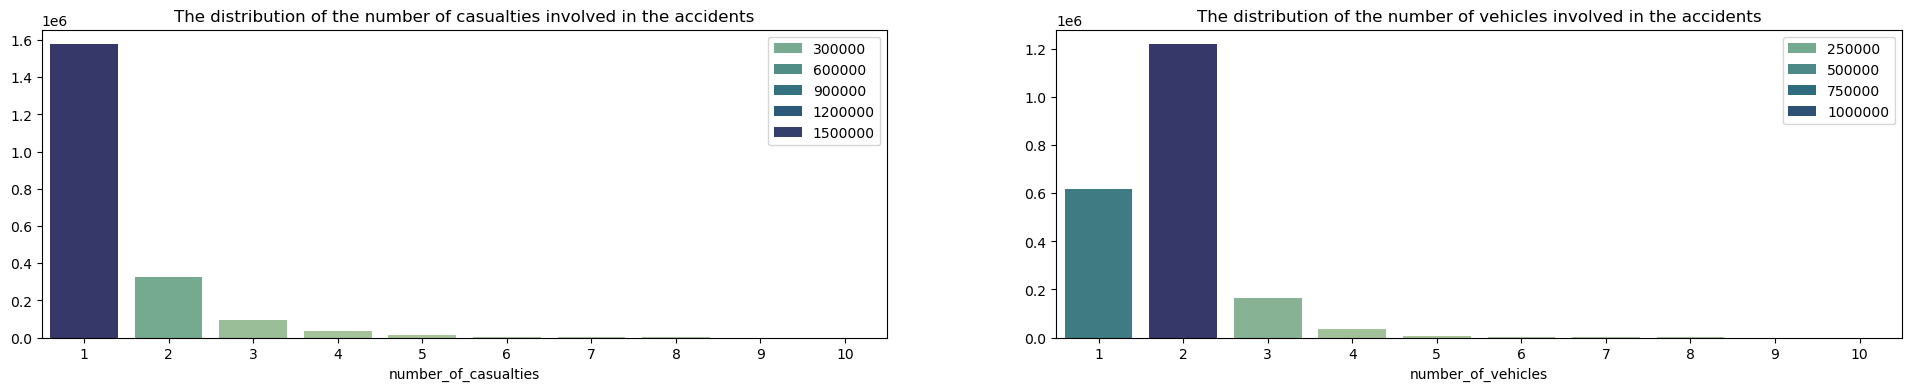

In [10]:
casualties_counts = df[df['number_of_casualties'] <= 10]['number_of_casualties'].value_counts().sort_index()
vehicles_counts = df[df['number_of_vehicles'] <= 10]['number_of_vehicles'].value_counts().sort_index()
fig, ax=plt.subplots(1,2)
fig.set_size_inches(24,4)
sns.barplot(x=casualties_counts.index, y=casualties_counts.values, palette='crest', hue=casualties_counts.values, ax=ax[0])
sns.barplot(x=vehicles_counts.index, y=vehicles_counts.values, palette='crest', hue=vehicles_counts.values, ax=ax[1])
ax[0].set_title('The distribution of the number of casualties involved in the accidents')
ax[1].set_title('The distribution of the number of vehicles involved in the accidents')
pass

In [11]:
def aggregate(period='M') -> pd.DataFrame:
    df['number_of_accidents'] = 1
    aggregated_df = (
        df.groupby(df['timestamp'].dt.to_period(period))[
            ['number_of_casualties', 'number_of_vehicles', 'number_of_accidents']]
        .sum()
        .reset_index()
        .rename({'timestamp': 'period'}, axis="columns")
    )
    aggregated_df['end_timestamp'] = aggregated_df['period'].dt.end_time.dt.ceil(
        'D')
    return aggregated_df


daily_df = aggregate('D')
weekly_df = aggregate('W')[1:-1]
monthly_df = aggregate('M')
quarterly_df = aggregate('Q')
yearly_df = aggregate('Y')

## Exploratory analysis
Once we've prepared the dataset and obtained a "found" time series, we scour it in search of significant properties that will be fundamental to later forecasting analysis. Each of the following charts will be wrangled to uncover the underlying features of interest.

### Search for trends and seasonality
We begin our exploratory analysis by plotting the aggregated weekly trend of accidents and casualties.
From the plot we can draw some considerations. 

First of all, the two measures are almost perfectly correlated, with a correlation coefficient of *0,992*. This is to be expected as the number of casualties can be considered as the sum of the number of accidents plus a stochastic component with the above probability distribution with a mean of *1,346*. That being said, it's safe to focus solely on the time series of the numbers of accidents.

There's a clear **negative trend** in the series. 
* During each year, the number of accidents **per week increases** linearly throughout the year.
* However, there is usually a gradual **decrease from year to year** with the exception of 2014, when the total number of accidents increased by *5,48%* - yellow area in figure.

There's also a clear **yearly seasonality** in the data.
* There is clear pattern which repeats every year which derives from the fact that *humans are creature of habit*.
* The lowest number of accidents always occurs in the first weeks of January, probably due to the New Year holidays and the resulting reduction in traffic..

/tmp/ipykernel_47723/1932809092.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


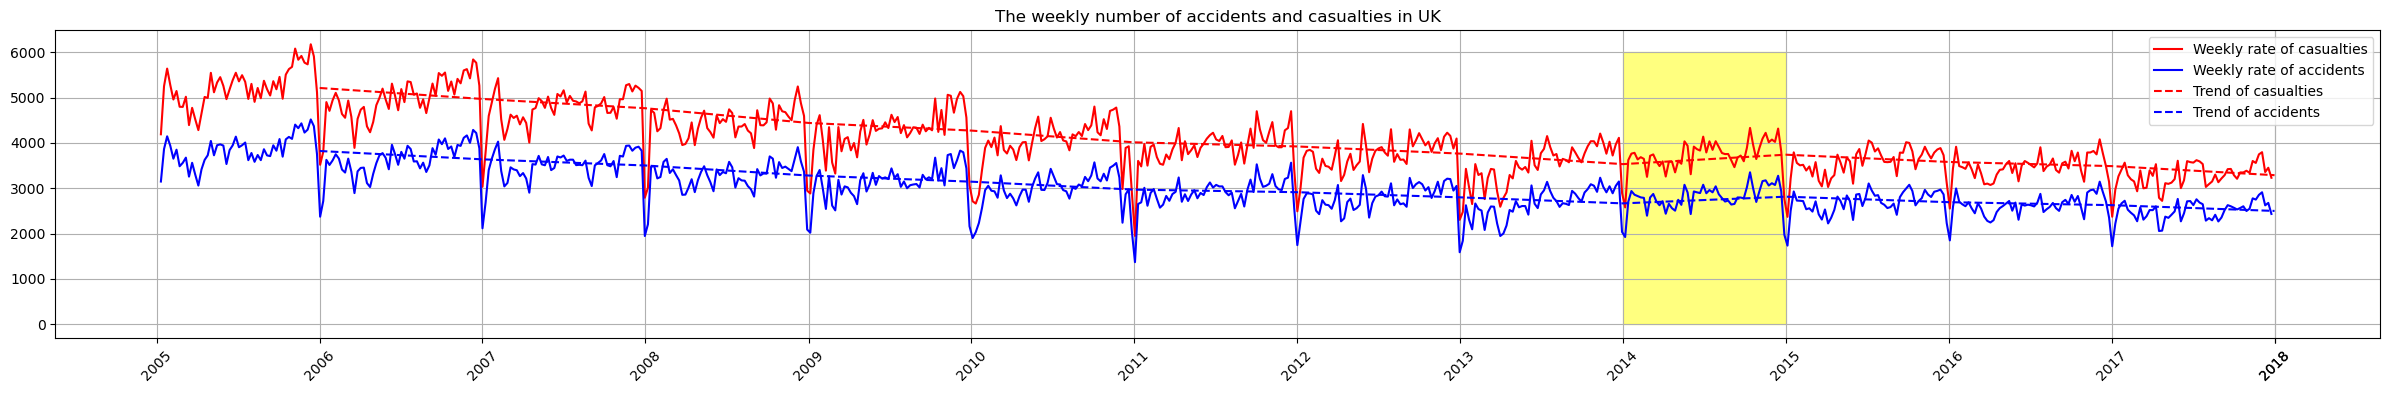

In [ ]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(30, 4)
ax.plot(weekly_df['end_timestamp'], weekly_df["number_of_casualties"],
        color="red", label="Weekly rate of casualties", linestyle="-")
# ax.plot(weekly_df['end_timestamp'], weekly_df["number_of_accidents"]*1.345858, color="red", label="Number of casualties", linestyle="--")
ax.plot(weekly_df['end_timestamp'], weekly_df["number_of_accidents"],
        color="blue", label="Weekly rate of accidents", linestyle="-")
ax.plot(yearly_df['end_timestamp'], yearly_df["number_of_casualties"]/52,
        color="red", label="Trend of casualties", linestyle="--", alpha=1)
ax.plot(yearly_df['end_timestamp'], yearly_df["number_of_accidents"]/52,
        color="blue", label="Trend of accidents", linestyle="--", alpha=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
unique_years = np.sort(
    np.append(monthly_df['end_timestamp'].dt.year.unique(), 2018))
plt.xticks(ticks=pd.to_datetime(
    unique_years, format='%Y'), labels=unique_years)
plt.title('The weekly number of accidents and casualties in UK')
plt.fill_between([datetime.datetime(2014, 1, 1), datetime.datetime(
    2015, 1, 1)], [6000, 6000], color='yellow', alpha=0.5)
plt.legend()
plt.grid()
plt.show()

### Additive or multiplicative seasonality?

To determine the nature of the seasonality, we need to decompose the original time series into a seasonal component, a trend and the residuals.
For this purpose, we exploit the [`statsmodels`'s `STL` class](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL). `STL` implements the decomposition using the *LOESS algorithm*, which is an acronym for Locally Estimated Scatter plot Smoothing. To apply the smooth, *LOESS* fits a low degree polynomial to each point in the time series.

The decomposition articulates in the following three steps:
1. *LOESS* is used on the seasonal subseries, to extract the **seasonal component**. With seasonal subseries we mean the weekly subseries one for each year. So what LOESS does here is to average the number of accidents for each week of the year, based on the values that the time series takes in that week, for all the years.
2. Once the seasonal component has been extracted, it is subtracted from the original time series and the resulting series is smoothed again with a moving average to determine the **trend**. The mean of the seasonal component is subtracted from it and added to the trend component.
3. The trend is then subtracted to obtain the **residuals**.

The goodness of the found components depends on how the seasonal period is chosen. In our context, it is clear that since we have observed an annual seasonality and the series is sampled on a weekly basis, the period is 52. 

To determine the nature of the seasonality, we need to look at the residuals. If the series is truly additive, there shouldn't be any significant patterns in them, but instead **they should be due to a purely stochastic process**, i.e. white noise.

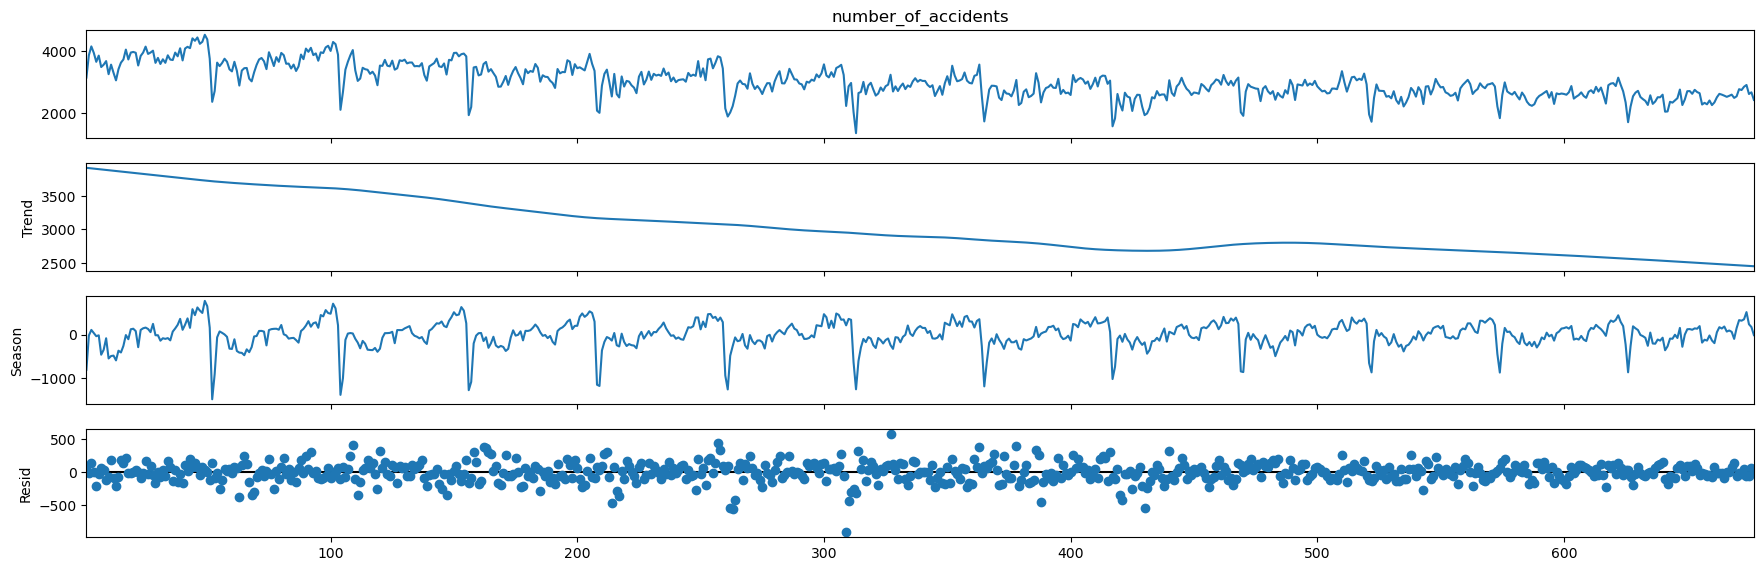

In [ ]:
stl = STL(weekly_df['number_of_accidents'], period=52)
result_stl = stl.fit()
result_stl.plot().set_size_inches(20, 6)
plt.show()

The `STL` decomposition finds a trend and seasonal components very much in line with the arguments made in the previous section, such as the exceptional increase in the number of accidents in 2014, to name but one. However, while the **residuals don't suggest multiplicative seasonality, they don't rule it out either**, as their variance seems to decrease slightly in line with the trend.

To get to the bottom of this, we need to carry out a more in-depth analysis. First, we plot both the additive and multiplicative residuals for comparison.

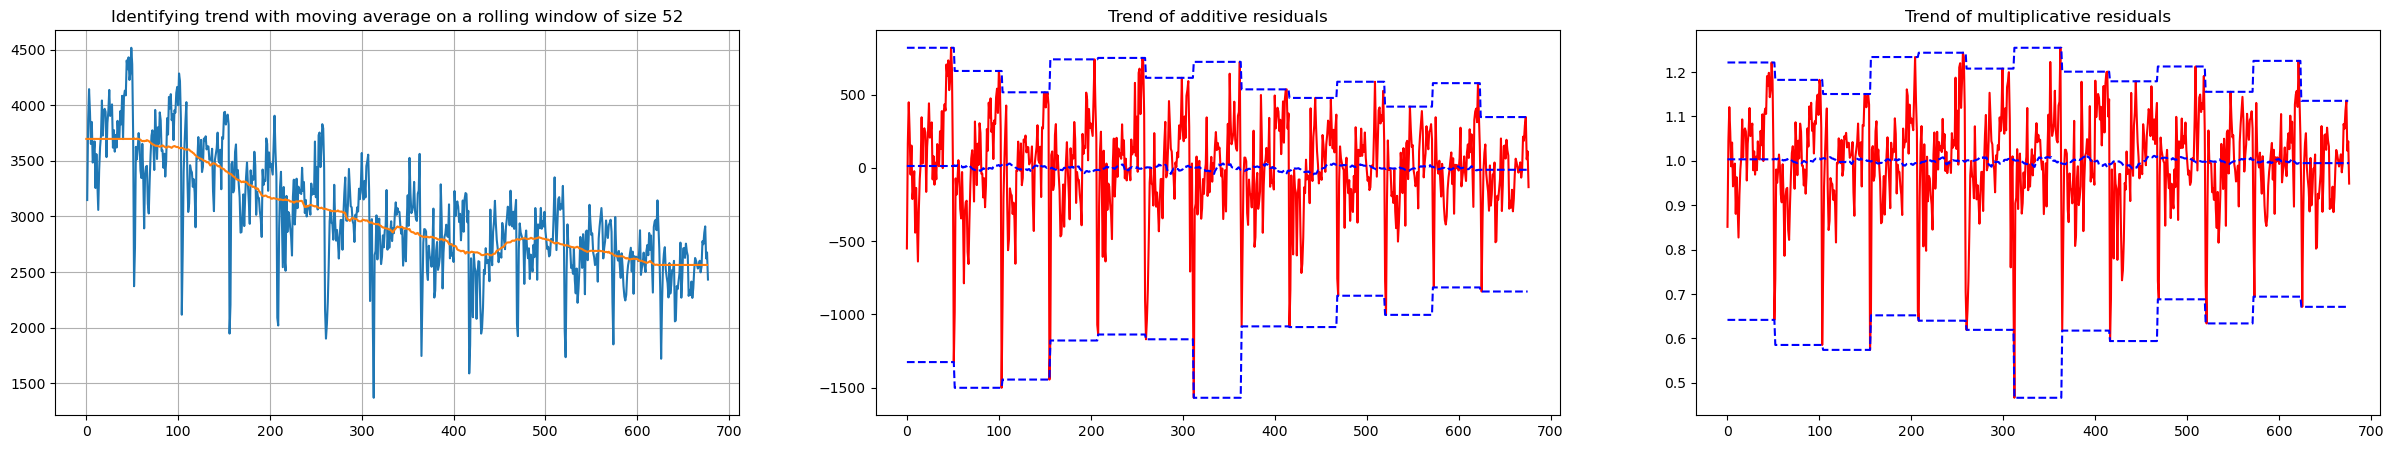

In [308]:
def moving_average(data, n=3):
    window = np.ones(n)/float(n)
    ma = np.convolve(data, window, 'same')
    ma[:n] = ma[n+1]
    ma[-n:] = ma[-n-1]
    return ma


def moving_max(data, n):
    return np.repeat(np.maximum.reduceat(data, np.arange(0, len(data), n)), n)[:-n]


def moving_min(data, n):
    return np.repeat(np.minimum.reduceat(data, np.arange(0, len(data), n)), n)[:-n]


rolling_window = 52
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(30, 5)

trend = moving_average(weekly_df['number_of_accidents'], 52)
ax[0].set_title(
    'Identifying trend with moving average on a rolling window of size 52')
ax[0].plot(weekly_df['number_of_accidents'])
ax[0].plot(trend)
ax[0].grid()

additive_residuals = (weekly_df['number_of_accidents']-trend).to_numpy()
ax[1].set_title('Trend of additive residuals')
ax[1].plot(additive_residuals, color='r')
ax[1].plot(moving_average(additive_residuals, rolling_window), color='b', linestyle="--")
ax[1].plot(moving_max(additive_residuals, rolling_window), color='b', linestyle="--")
ax[1].plot(moving_min(additive_residuals, rolling_window), color='b', linestyle="--")

multiplicative_residuals = (weekly_df['number_of_accidents']/trend).to_numpy()
ax[2].set_title('Trend of multiplicative residuals')
ax[2].plot(multiplicative_residuals, color='r')
ax[2].plot(moving_average(multiplicative_residuals, rolling_window),
           color='b', linestyle="--")
ax[2].plot(moving_max(multiplicative_residuals, rolling_window),
           color='b', linestyle="--")
ax[2].plot(moving_min(multiplicative_residuals, rolling_window),
           color='b', linestyle="--")

plt.show()

Once again, the difference is so subtle that we can't rely on quick observation to determine the true nature of the seasonality. What we can do, however, is to examine the stationarity of the residuals, for example using the Augmented Dickey Fuller Hypothesis Test.

In [336]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value']
    df_test = adfuller(ts)
    df_results = pd.Series(df_test[0:2], index=stats)
    print('ADF statistic:', df_results.iloc[0])
    print('P-value:', df_results.iloc[1])

test_stationarity(additive_residuals)
test_stationarity(multiplicative_residuals)

ADF statistic: -11.122651478308608
P-value: 3.435162638809344e-20
ADF statistic: -11.062667260963568
P-value: 4.7661936877001094e-20


We can thus conclude that the seasonality is additive.

### Nested trends
To highlight the trends in the series even more, we can produce some more visualizations.

* Plotting the **per-year month-by-month accidents counts**, we can get a different point of view of the yearly seasonality and confirm once again the negative trend of the accidents through the years. The overlap of the different sub-series on the same graphs also shows how the accidents are distributed over the months, with March being the safest and December the most dangerous.

* Plotting the **per-month year-by-year accidents counts**, we look at the opposite point of view. Here we highlight the seasonal trends over the years.

/tmp/ipykernel_47723/333454713.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


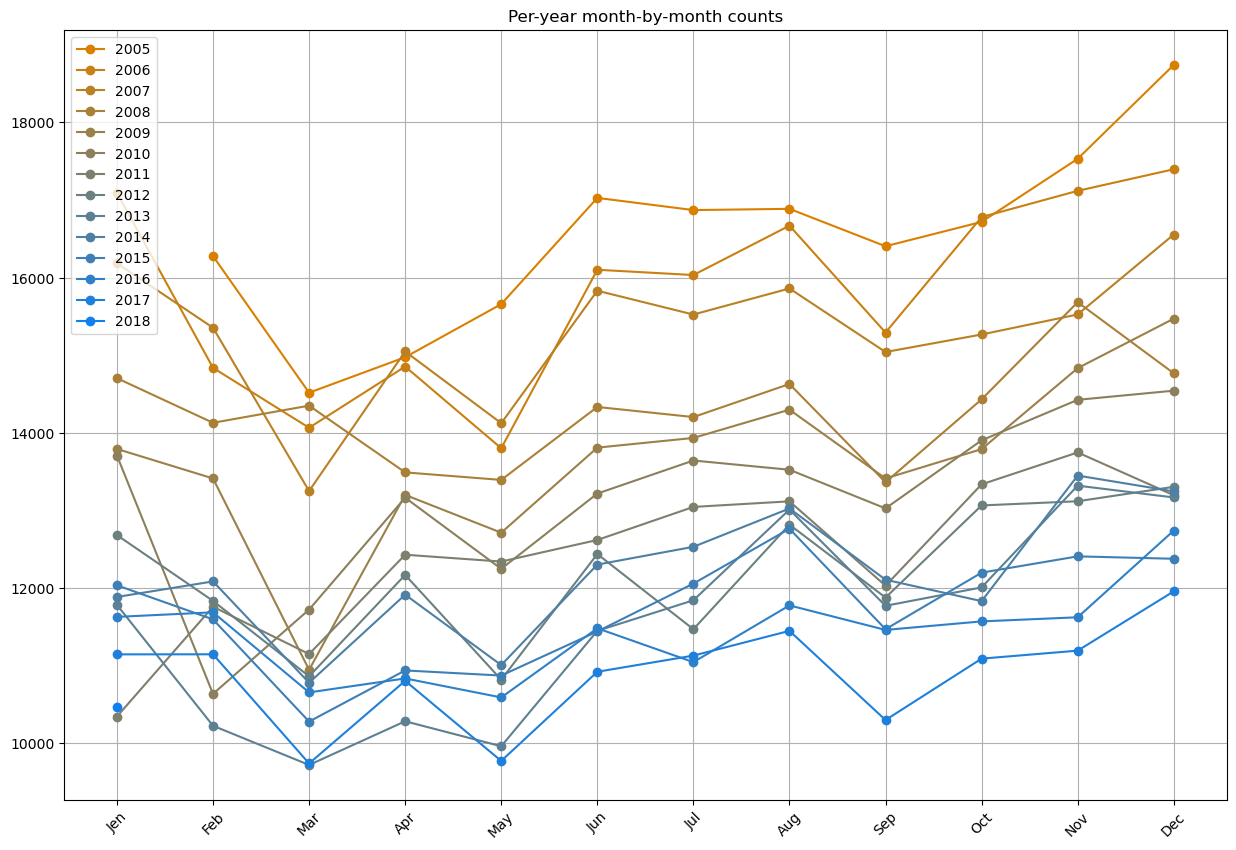

In [ ]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(15, 10)

years = monthly_df['end_timestamp'].dt.year.unique()
for i, year in enumerate(years):
    _ = monthly_df[monthly_df['end_timestamp'].dt.year == year]
    hue = (i/len(years))
    ax.plot(_['end_timestamp'].dt.month, _["number_of_accidents"],
            color=(0.85-hue*0.85, 0.5, hue), label=f'{year}', marker='o')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(ticks=range(1, 13), labels=[
           'Jen', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('Per-year month-by-month counts')
plt.legend(loc='upper left')
plt.grid()
plt.show()

/tmp/ipykernel_47723/3859340415.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


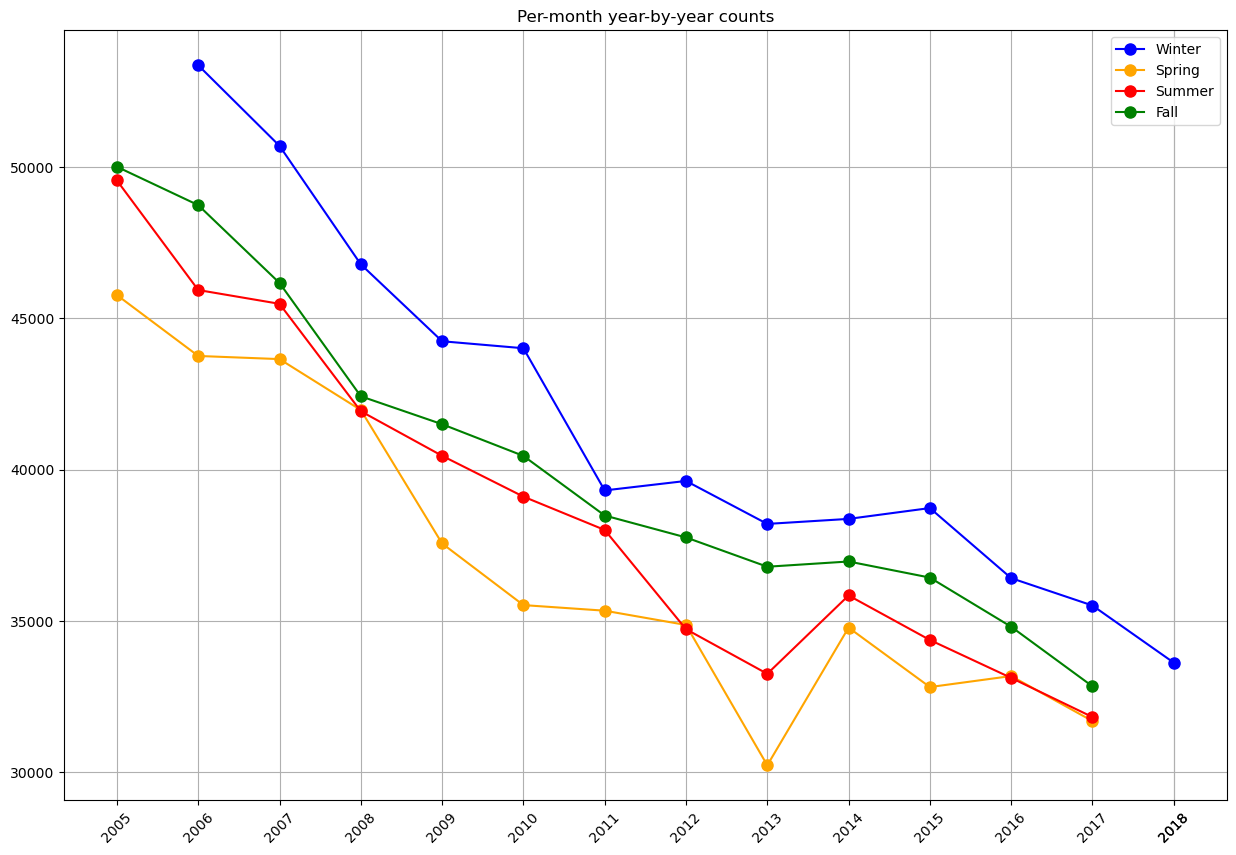

In [343]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(15, 10)

for i, months in enumerate([[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
    _ = quarterly_df[quarterly_df['end_timestamp'].dt.month.isin(months)]
    hue = (i/4)
    ax.plot(_['end_timestamp'].dt.year, _["number_of_accidents"], color=['b', 'orange', 'r', 'g'][i], label=['Winter', 'Spring', 'Summer', 'Fall'][i],
            marker='o',  markersize=8)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
unique_years = np.sort(
    np.append(monthly_df['end_timestamp'].dt.year.unique(), 2018))
plt.xticks(ticks=unique_years, labels=unique_years)
ax.set_title('Per-month year-by-year counts')
plt.legend()
plt.grid()
plt.show()

### The danger of the accidents

The weekly number of persons killed per accident time series shows a more pronounced seasonal component and an overall negative trend. This suggests a reduction in the risk of car accidents, probably due to technological advances such as assisted braking or safer airbags, which may save one of the two drivers involved from being considered a casualty.

/tmp/ipykernel_47723/2842727250.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


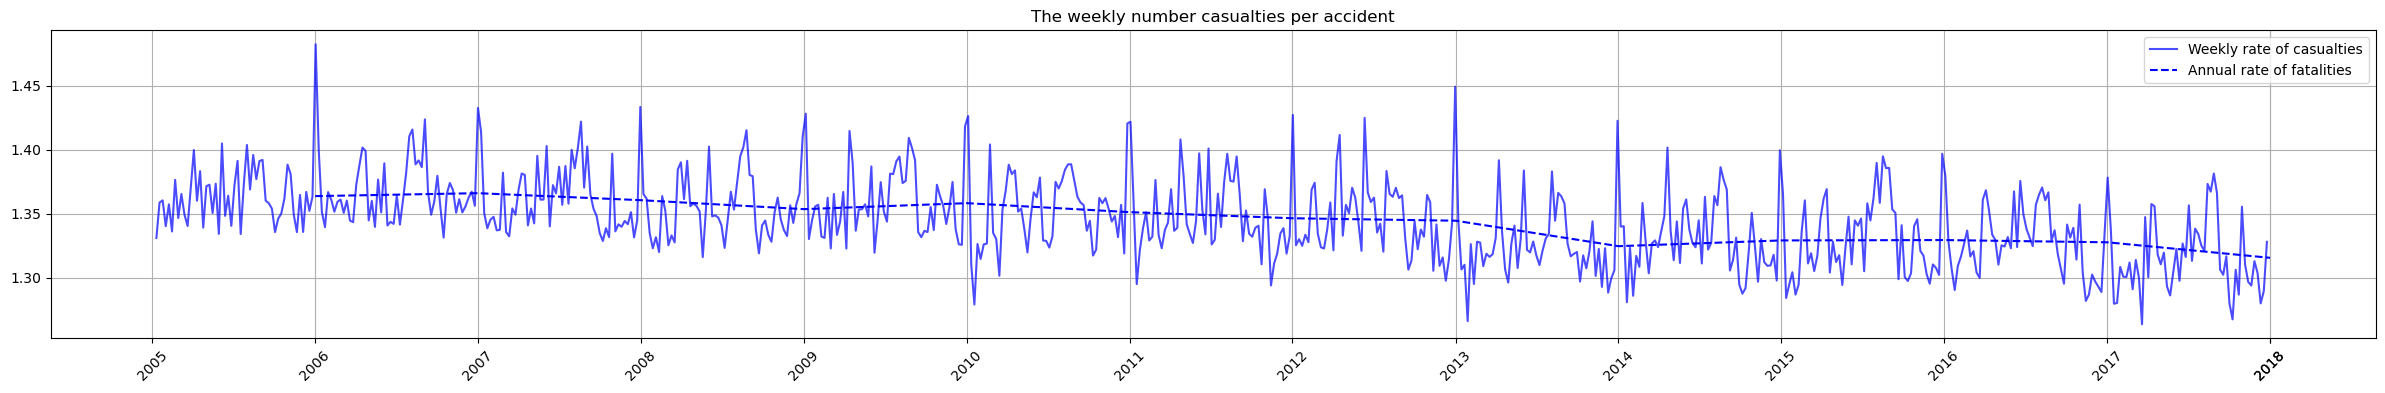

In [ ]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(30,4)
ax.plot(weekly_df['end_timestamp'], weekly_df["number_of_casualties"]/weekly_df["number_of_accidents"], color="blue", label="Weekly rate of casualties", linestyle="-",alpha=0.7)
ax.plot(yearly_df['end_timestamp'], yearly_df["number_of_casualties"]/yearly_df["number_of_accidents"], color="blue", label="Annual rate of fatalities", linestyle="--")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
unique_years = np.sort(np.append(monthly_df['end_timestamp'].dt.year.unique(),2018))
plt.xticks(ticks=pd.to_datetime(unique_years, format='%Y'), labels=unique_years)
plt.title('The weekly number of casualties per accident')
plt.legend()
plt.grid()
plt.show()

## Forecasting

<!-- 
- Spiega la critical region di ACF/PACF
- stagionality is additive or multiplicative? study the stationarity of residuals
- [stationarity] -> Aug Dickey Fuller (and KPSS?) oppure con PACF drops to zero quickly and is contained in the boundary
- BoxCox
-->